In [1]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Set plot style
plt.style.use('seaborn-v0_8')

In [2]:
# Define data transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Load MNIST dataset
train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('./data', train=False, transform=transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)

print("Training data size:", len(train_dataset))
print("Testing data size:", len(test_dataset))

100%|██████████| 9.91M/9.91M [00:00<00:00, 17.8MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 482kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.43MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 4.28MB/s]

Training data size: 60000
Testing data size: 10000


In [3]:
# Define the CNN model
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3)
        self.pool = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(64 * 3 * 3, 64)
        self.fc2 = nn.Linear(64, 10)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = torch.relu(self.conv3(x))
        x = x.view(-1, 64 * 3 * 3)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Create model instance
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN().to(device)
print(model)

CNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=576, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=10, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


In [4]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

# Training function
def train(model, device, train_loader, optimizer, criterion, epoch):
    model.train()
    running_loss = 0
    correct = 0
    total = 0

    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
        total += target.size(0)

        if batch_idx % 100 == 0:
            print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} '
                  f'({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}')

    return running_loss / len(train_loader), 100. * correct / total

# Training loop
epochs = 10
train_losses = []
train_accs = []

for epoch in range(1, epochs + 1):
    loss, acc = train(model, device, train_loader, optimizer, criterion, epoch)
    train_losses.append(loss)
    train_accs.append(acc)
    print(f'Epoch {epoch}: Average loss: {loss:.4f}, Accuracy: {acc:.2f}%')

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.304053
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.570453
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.334314
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.233629
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.095362
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.129812
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.238059
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.129315
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.074093
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.203523
Epoch 1: Average loss: 0.2860, Accuracy: 91.29%
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.051748
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.061463
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.017759
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.050128
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.033189
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.116761
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.055377
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.026725
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.119786
Train Epoch: 2

Test set: Average loss: 0.0282, Accuracy: 99.25%

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       980
           1       0.99      1.00      1.00      1135
           2       1.00      0.99      0.99      1032
           3       0.99      1.00      0.99      1010
           4       0.99      1.00      0.99       982
           5       0.99      0.99      0.99       892
           6       0.99      0.99      0.99       958
           7       0.98      0.99      0.99      1028
           8       1.00      0.99      1.00       974
           9       0.99      0.98      0.99      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



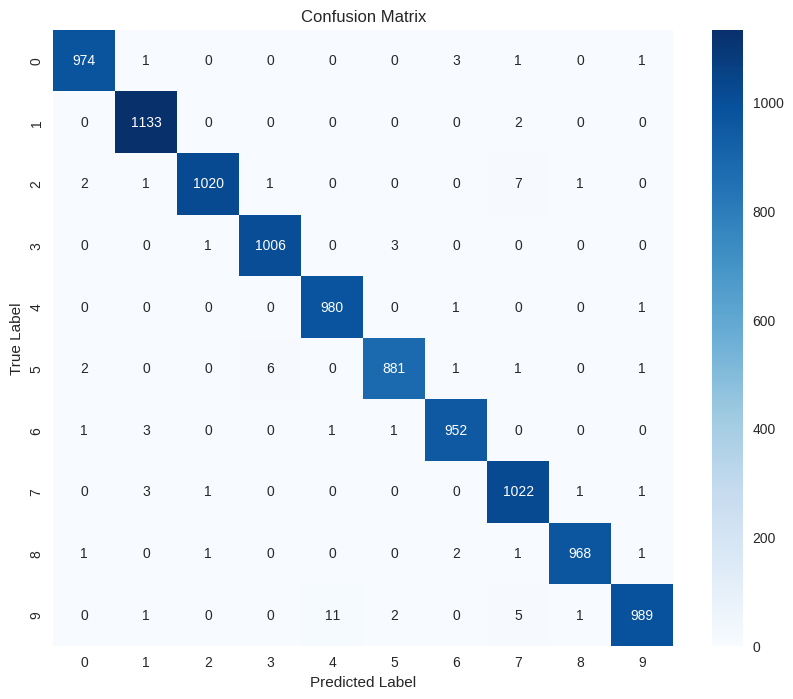

In [5]:
# Evaluation function
def evaluate(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
            all_preds.extend(pred.cpu().numpy())
            all_targets.extend(target.cpu().numpy())

    test_loss /= len(test_loader)
    accuracy = 100. * correct / len(test_loader.dataset)
    print(f'Test set: Average loss: {test_loss:.4f}, Accuracy: {accuracy:.2f}%')
    return all_preds, all_targets

# Evaluate the model
all_preds, all_targets = evaluate(model, device, test_loader)

# Print classification report
print("\nClassification Report:")
print(classification_report(all_targets, all_preds))

# Create confusion matrix
plt.figure(figsize=(10, 8))
cm = confusion_matrix(all_targets, all_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

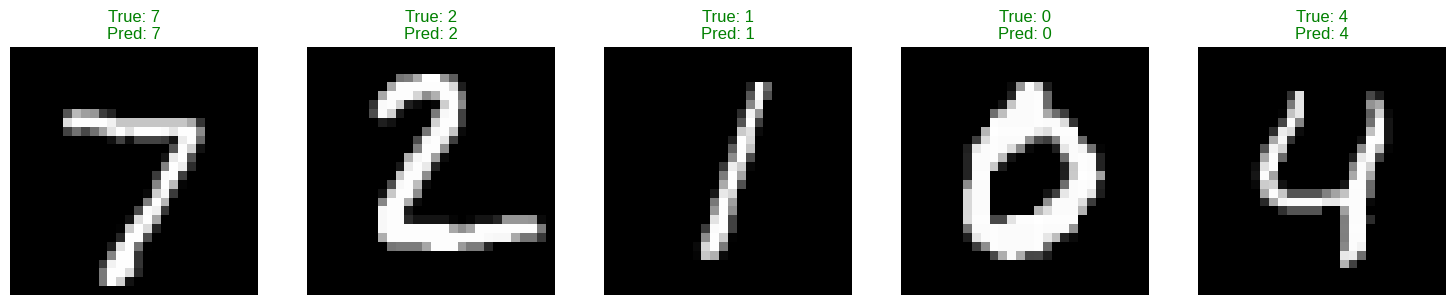

In [6]:
# Visualize predictions
def plot_sample_predictions(model, device, test_loader, num_samples=5):
    model.eval()
    dataiter = iter(test_loader)
    images, labels = next(dataiter)

    plt.figure(figsize=(15, 3))
    for i in range(num_samples):
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(images[i].squeeze().numpy(), cmap='gray')
        with torch.no_grad():
            output = model(images[i:i+1].to(device))
            pred = output.argmax(dim=1, keepdim=True)
        true_label = labels[i].item()
        pred_label = pred.item()
        color = 'green' if true_label == pred_label else 'red'
        plt.title(f'True: {true_label}\nPred: {pred_label}', color=color)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Plot sample predictions
plot_sample_predictions(model, device, test_loader)